In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

df = pd.read_csv('D:\元光科技\\advtertise\\avazu-ctr-prediction\\test.csv')
df.head()

,datetime,click
0,10-21 0:00,0.174714
1,10-21 1:00,0.173695
2,10-21 2:00,0.150696
3,10-21 3:00,0.169791
4,10-21 4:00,0.151206


In [3]:
# 将datetime列转换为日期时间类型
df['datetime'] = pd.to_datetime(df['datetime'], format='%m-%d %H:%M', errors='coerce')
df = df.set_index('datetime')
df = df.sort_index()

In [12]:
# 现在 df 的索引是 datetime 对象，列是 'click' (浮点数)
print("DataFrame 准备就绪：")
print(df.head())
print("\nDataFrame 信息：")
df.info()

DataFrame 准备就绪：
                        click
datetime                     
1900-10-21 00:00:00  0.174714
1900-10-21 01:00:00  0.173695
1900-10-21 02:00:00  0.150696
1900-10-21 03:00:00  0.169791
1900-10-21 04:00:00  0.151206

DataFrame 信息：
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1900-10-21 00:00:00 to 1900-10-30 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   click   240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [14]:
def check_time_continuity(df, freq='H'):
    """
    检查 DataFrame 的时间索引是否连续。

    Args:
        df (pd.DataFrame): 带有 datetime 索引的 DataFrame。
        freq (str): 期望的时间频率，例如 'H' 表示小时。

    Returns:
        tuple: (is_continuous, missing_time_points)
               is_continuous (bool): 如果时间序列连续则为 True。
               missing_time_points (pd.DatetimeIndex): 缺失的时间点列表。
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        print("错误：DataFrame 索引不是 DatetimeIndex 类型。")
        return False, None

    if df.empty:
        print("警告：DataFrame 为空。")
        return True, pd.DatetimeIndex([])

    # 获取时间范围的开始和结束点
    start_time = df.index.min()
    end_time = df.index.max()

    # 生成从开始到结束的完整、期望的时间范围
    expected_range = pd.date_range(start=start_time, end=end_time, freq=freq)

    # 检查实际索引是否与期望范围完全一致
    # 方法1: 比较长度（快速判断是否有缺失或多余的点）
    is_length_match = len(df.index) == len(expected_range)

    # 方法2: 查找缺失点（更精确，能找到是哪些点缺失）
    missing_points = expected_range.difference(df.index)

    is_continuous = missing_points.empty and is_length_match # 必须既没有缺失点，长度也匹配（防止多余点的情况，尽管不太常见）

    return is_continuous, missing_points

In [15]:
# --- 调用函数检查时间序列的连续性 ---
expected_frequency = 'H' # 定义你的期望频率，这里是小时

is_continuous, missing_times = check_time_continuity(df, freq=expected_frequency)

if is_continuous:
    print(f"\n时间序列是连续的，频率为 {expected_frequency}。")
else:
    print(f"\n时间序列不连续，频率应为 {expected_frequency}。")
    print(f"总共有 {len(missing_times)} 个缺失点。")
    if len(missing_times) > 0:
        print("前 10 个缺失点示例：")
        print(missing_times[:10]) # 打印前 10 个缺失点，避免列表过长



时间序列是连续的，频率为 H。


C:\Windows\Temp\ipykernel_35256\795765548.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_range = pd.date_range(start=start_time, end=end_time, freq=freq)


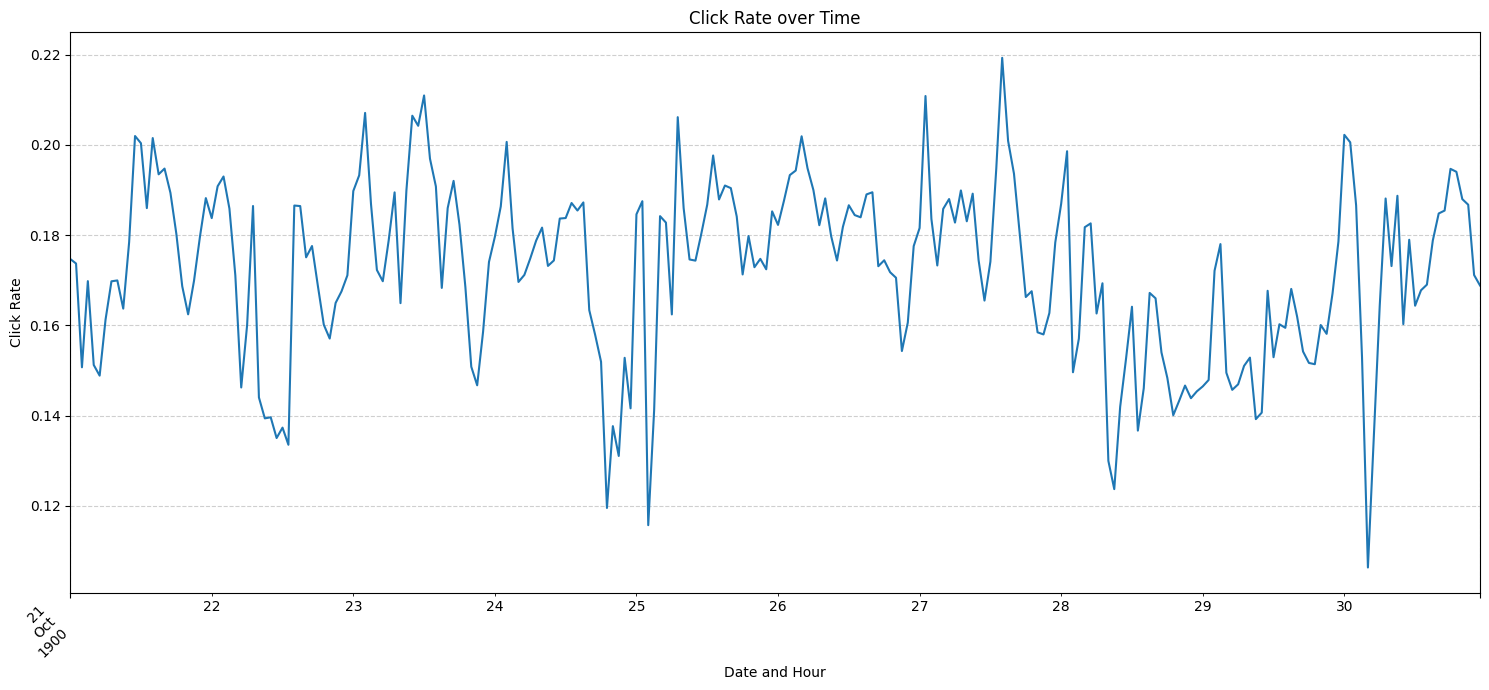

In [13]:
# 准备好 df 之后，可以这样快速绘图：
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
# 直接使用 pandas 的 plot 功能，如果索引是 datetime 会自动处理 X 轴
df['click'].plot()

# 或者继续使用 seaborn (x 轴指定索引名，y 轴指定列名)
# sns.lineplot(x=df.index, y=df['click']) # 如果 datetime 是索引的话

plt.title('Click Rate over Time')
plt.xlabel('Date and Hour')
plt.ylabel('Click Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right') # 继续旋转标签以防重叠
plt.tight_layout()
plt.show()

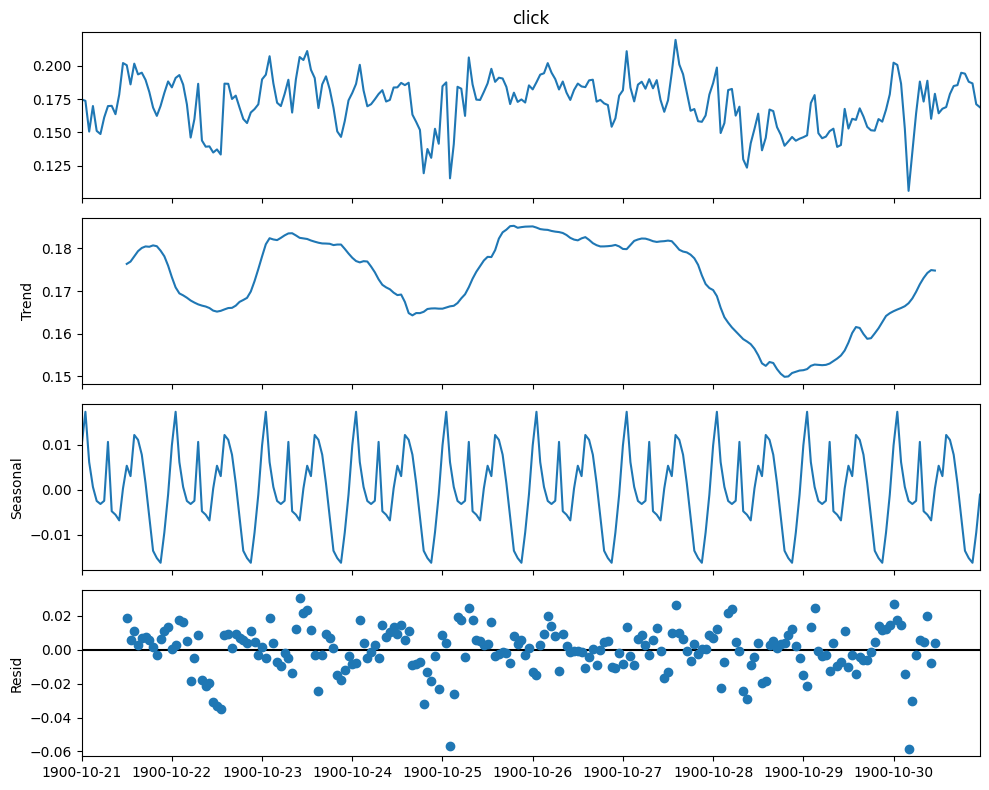

In [16]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 假设 df 已经加载并设置了 datetime 索引，包含 'click' 列

# --- 1. 时间序列分解 ---
# multiplicative 模式通常适用于波动幅度随时间序列水平变化的场景
# additive 模式适用于波动幅度相对稳定的场景。从图上看，波动幅度似乎相对稳定，先尝试 additive
decomposition = sm.tsa.seasonal_decompose(df['click'], model='additive', period=24) # 周期是 24 小时

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

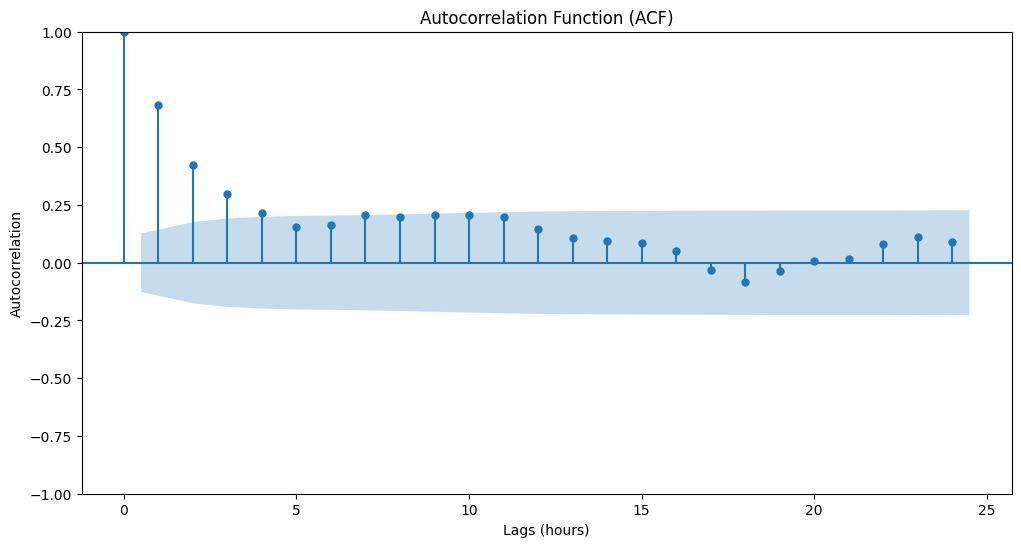

In [17]:
# --- 2. 自相关和偏自相关图 ---

# 绘制 ACF 图
plt.figure(figsize=(12, 6))
plot_acf(df['click'], lags=24, ax=plt.gca()) # lags 设置最大滞后数，例如看过去 48 小时
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags (hours)')
plt.ylabel('Autocorrelation')
plt.show()

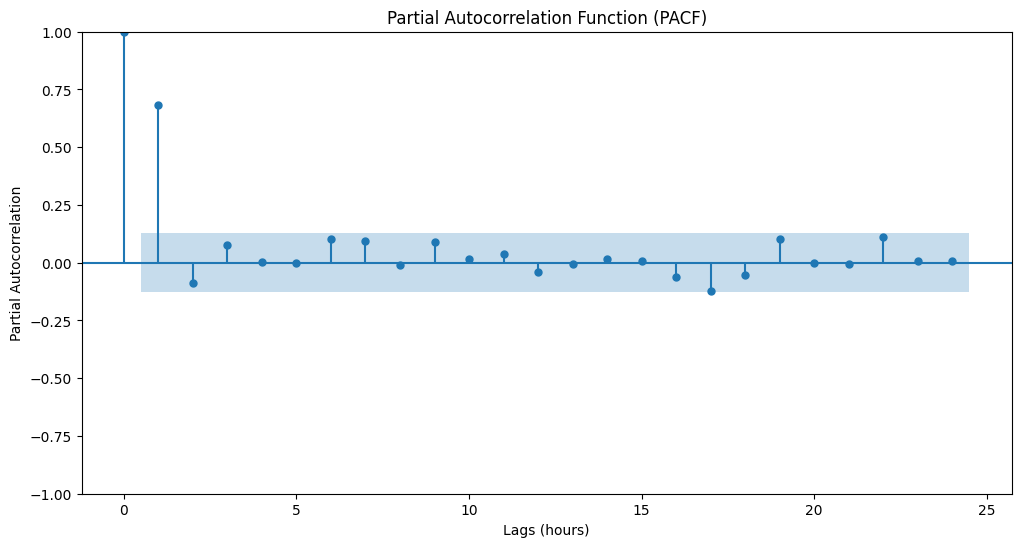

In [18]:
# 绘制 PACF 图
plt.figure(figsize=(12, 6))
plot_pacf(df['click'], lags=24, ax=plt.gca()) # lags 设置最大滞后数
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags (hours)')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['click'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] > 0.05:
    print("数据可能不平稳")
else:
    print("数据似乎是平稳的")

ADF Statistic: -6.648076
p-value: 0.000000
数据似乎是平稳的


In [24]:
# 导入必要的库
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决保存图像时负号'-'显示为方块的问题

In [44]:
# 确保数据是数值类型
df['click'] = pd.to_numeric(df['click'], errors='coerce')
data = df['click'].dropna()

# 划分训练集和测试集
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

# 使用AIC准则选择最优滞后阶数
max_lag = 24  # 考虑最大24阶
best_aic = np.inf
best_lag = 0


In [45]:
for lag in range(1, max_lag + 1):
    model = AutoReg(train, lags=lag)
    results = model.fit()
    aic = results.aic
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

print(f"最优滞后阶数: {best_lag}")

# 使用最优滞后阶数拟合AR模型
model = AutoReg(train, lags=24)
model_fit = model.fit()

# 打印模型摘要
print("\nAR模型摘要:")
print(model_fit.summary())

最优滞后阶数: 1

AR模型摘要:
                            AutoReg Model Results                             
Dep. Variable:                  click   No. Observations:                  192
Model:                    AutoReg(24)   Log Likelihood                 484.892
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Thu, 15 May 2025   AIC                           -917.783
Time:                        15:24:23   BIC                           -836.560
Sample:                    10-22-1900   HQIC                          -884.819
                         - 10-28-1900                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0488      0.026      1.842      0.065      -0.003       0.101
click.L1       0.6992      0.077      9.061      0.000       0.548       0.850
click.L2      -0.1557      0.094 

d:\program\python3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\program\python3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\program\python3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\program\python3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\program\python3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

In [47]:
# 进行预测
predictions = model_fit.predict(start=train_size, end=len(data)-1)

# 计算预测误差
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f"\n均方根误差 (RMSE): {rmse:.6f}")



均方根误差 (RMSE): 0.020130


d:\program\python3.12\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


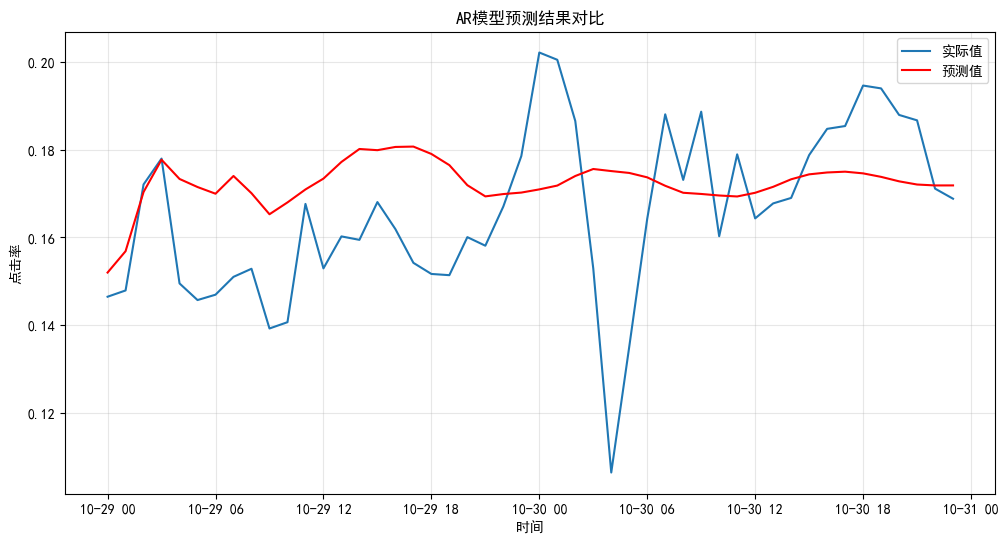

In [48]:
 #可视化结果
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='实际值')
plt.plot(test.index, predictions, label='预测值', color='red')
plt.title('AR模型预测结果对比')
plt.xlabel('时间')
plt.ylabel('点击率')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

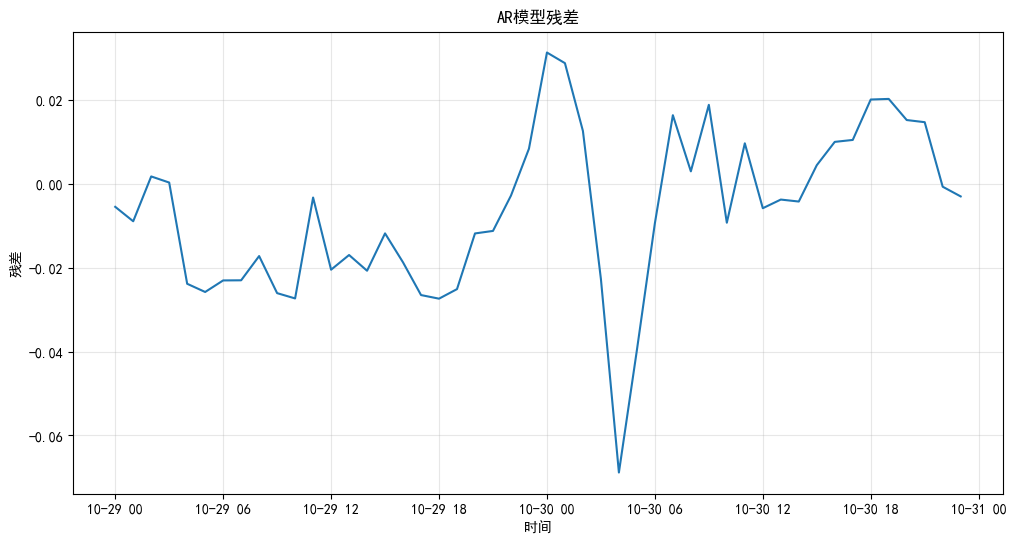

In [49]:
# 绘制残差图
residuals = test - predictions
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals.values)
plt.title('AR模型残差')
plt.xlabel('时间')
plt.ylabel('残差')
plt.grid(True, alpha=0.3)
plt.show()

In [56]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 创建特征和目标变量
def create_features(data, lookback=24):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)
# 使用过去24小时的数据作为特征
lookback = 24
X, y = create_features(data, lookback)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 数据标准化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()


C:\Windows\Temp\ipykernel_35256\374742549.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+lookback])


In [57]:
# 训练SVR模型
print("正在训练SVR模型...")
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled)

# 进行预测
y_pred_scaled = svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\n模型评估指标:")
print(f"均方根误差 (RMSE): {rmse:.6f}")
print(f"平均绝对误差 (MAE): {mae:.6f}")
print(f"平均绝对百分比误差 (MAPE): {mape:.6f}")


正在训练SVR模型...

模型评估指标:
均方根误差 (RMSE): 0.016339
平均绝对误差 (MAE): 0.012273
平均绝对百分比误差 (MAPE): 0.080171


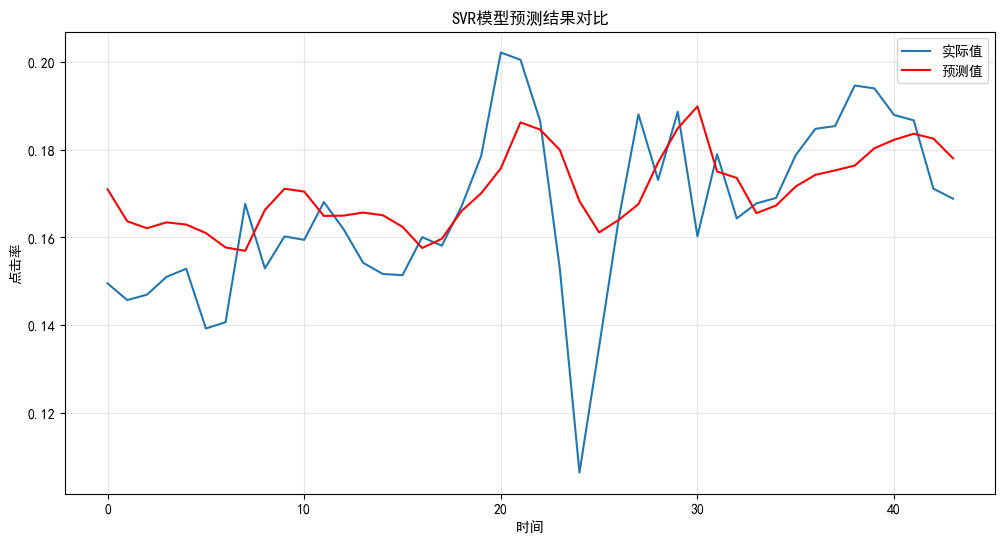

In [58]:
# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='实际值')
plt.plot(y_pred, label='预测值', color='red')
plt.title('SVR模型预测结果对比')
plt.xlabel('时间')
plt.ylabel('点击率')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


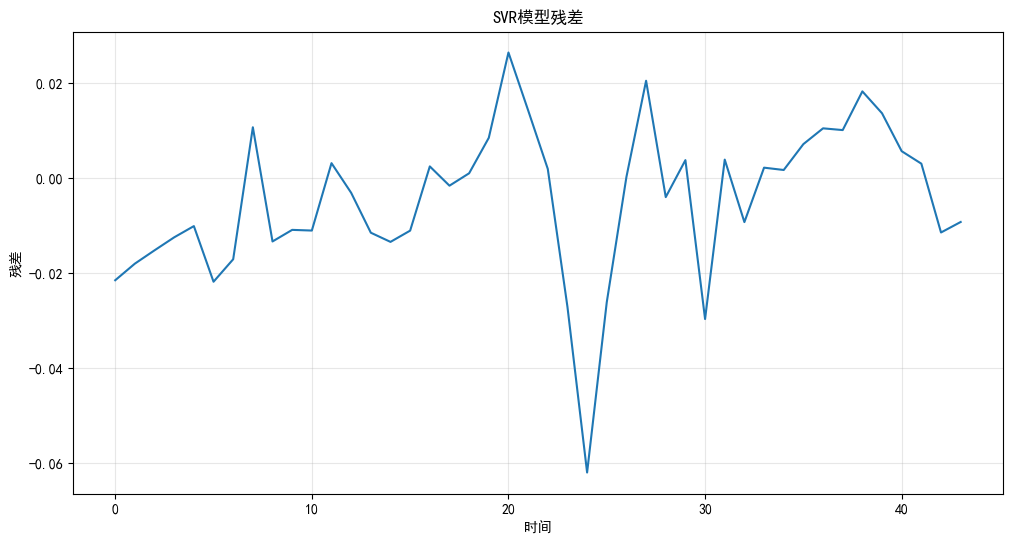

In [59]:
# 绘制残差图
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('SVR模型残差')
plt.xlabel('时间')
plt.ylabel('残差')
plt.grid(True, alpha=0.3)
plt.show()


In [60]:
# 网格搜索找最优参数（可选）
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 'auto', 0.1, 1]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

print("\n最优参数:")
print(grid_search.best_params_)

# 使用最优参数重新训练模型
best_svr = SVR(**grid_search.best_params_)
best_svr.fit(X_train_scaled, y_train_scaled)

# 使用最优模型进行预测
y_pred_best_scaled = best_svr.predict(X_test_scaled)
y_pred_best = scaler_y.inverse_transform(y_pred_best_scaled.reshape(-1, 1)).ravel()

# 计算最优模型的评估指标
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
mape_best = mean_absolute_percentage_error(y_test, y_pred_best)

print("\n最优模型评估指标:")
print(f"均方根误差 (RMSE): {rmse_best:.6f}")
print(f"平均绝对误差 (MAE): {mae_best:.6f}")
print(f"平均绝对百分比误差 (MAPE): {mape_best:.6f}")


最优参数:
{'C': 1, 'epsilon': 0.01, 'gamma': 'auto'}

最优模型评估指标:
均方根误差 (RMSE): 0.016214
平均绝对误差 (MAE): 0.012242
平均绝对百分比误差 (MAPE): 0.079891


开始训练...
Epoch [10/200], Train Loss: 0.0424, Test Loss: 0.0266
Epoch [20/200], Train Loss: 0.0326, Test Loss: 0.0238
Epoch [30/200], Train Loss: 0.0354, Test Loss: 0.0235
Epoch [40/200], Train Loss: 0.0326, Test Loss: 0.0227
Epoch [50/200], Train Loss: 0.0312, Test Loss: 0.0216
Epoch [60/200], Train Loss: 0.0336, Test Loss: 0.0212
Epoch [70/200], Train Loss: 0.0277, Test Loss: 0.0211
Epoch [80/200], Train Loss: 0.0321, Test Loss: 0.0218
Epoch [90/200], Train Loss: 0.0273, Test Loss: 0.0206
Epoch [100/200], Train Loss: 0.0267, Test Loss: 0.0203
Epoch [110/200], Train Loss: 0.0285, Test Loss: 0.0207
Epoch [120/200], Train Loss: 0.0289, Test Loss: 0.0195
Epoch [130/200], Train Loss: 0.0268, Test Loss: 0.0187
Epoch [140/200], Train Loss: 0.0244, Test Loss: 0.0176
Epoch [150/200], Train Loss: 0.0241, Test Loss: 0.0167
Epoch [160/200], Train Loss: 0.0221, Test Loss: 0.0164
Epoch [170/200], Train Loss: 0.0224, Test Loss: 0.0155
Epoch [180/200], Train Loss: 0.0215, Test Loss: 0.0148
Epoch [190/

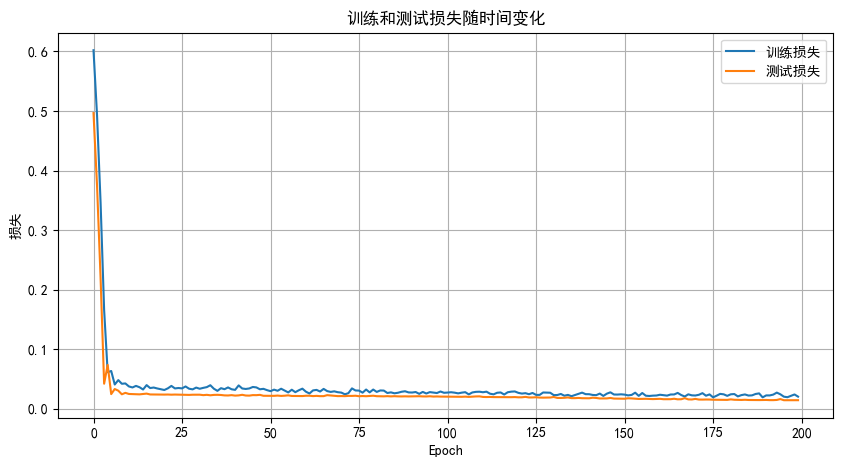

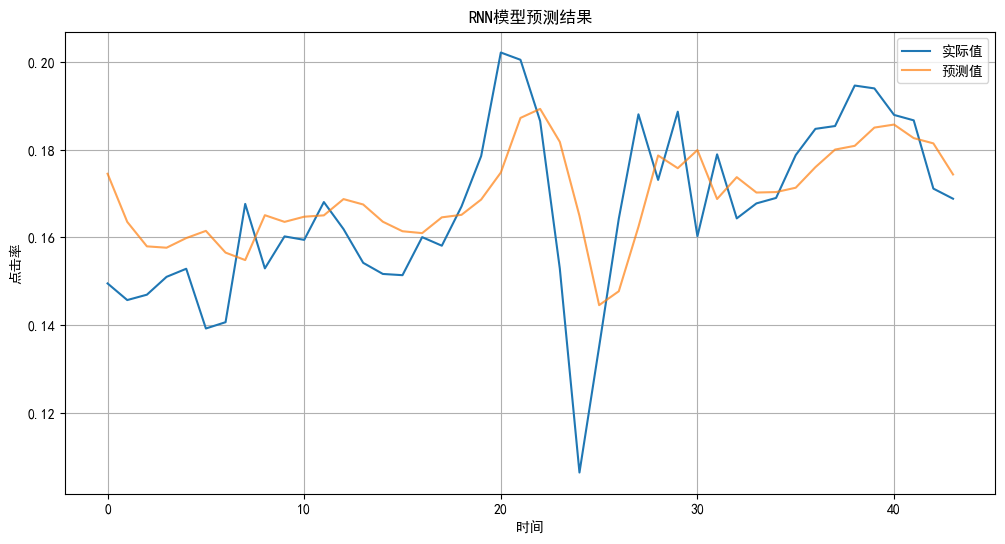

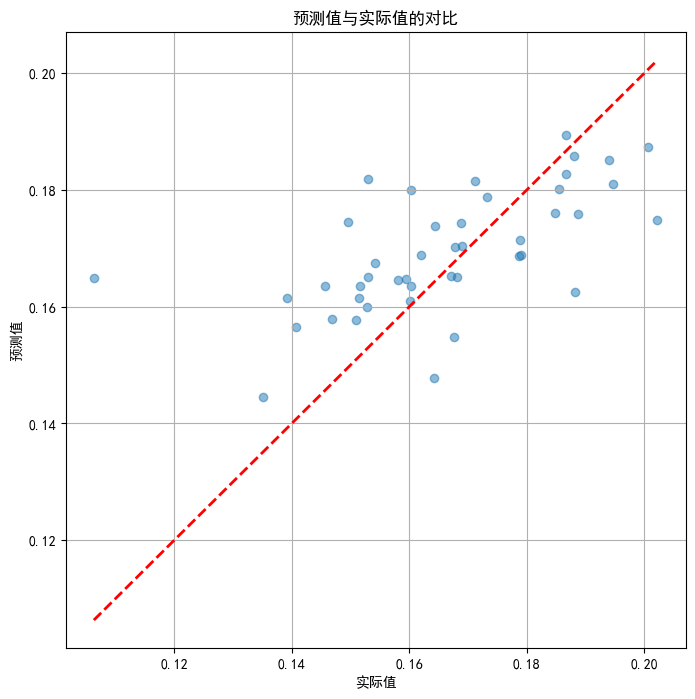

In [12]:
# 导入必要的库
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

# 准备数据
# 确保数据是数值类型
df['click'] = pd.to_numeric(df['click'], errors='coerce')
data = df['click'].dropna().values

# 数据标准化
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

# 创建序列数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# 设置序列长度为24（使用前24小时预测下一小时）
seq_length = 24
X, y = create_sequences(data_normalized, seq_length)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 创建PyTorch数据集
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建数据加载器
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # 定义RNN模型

# class SimpleRNN(nn.Module):
#     def __init__(self, input_size=1, hidden_size=32, output_size=1, dropout_rate=0.2):
#         super(SimpleRNN, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True, dropout=dropout_rate)
#         self.dropout = nn.Dropout(dropout_rate)  # 添加Dropout层
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.dropout(out[:, -1, :])  # 在RNN输出后应用dropout
#         out = self.fc(out)
#         return out
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM输出和隐藏状态
        out = self.dropout(out[:, -1, :])  # 取最后一个时间步的输出并应用dropout
        out = self.fc(out)
        return out
# # 初始化模型、损失函数和优化器
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SimpleRNN(dropout_rate=0.2).to(device)  # 设置dropout率为0.2
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(dropout_rate=0.2).to(device)  # 使用LSTM模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# 训练模型
num_epochs = 200
train_losses = []
test_losses = []

print("开始训练...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # 验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_loss += criterion(outputs, batch_y).item()
    
    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Test Loss: {test_loss/len(test_loader):.4f}')

# 预测
model.eval()
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

# 计算评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_orig, predictions))
mae = mean_absolute_error(y_test_orig, predictions)

print('\n模型评估指标:')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')

# 绘制训练过程中的损失变化
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='训练损失')
plt.plot(test_losses, label='测试损失')
plt.title('训练和测试损失随时间变化')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='实际值')
plt.plot(predictions, label='预测值', alpha=0.7)
plt.title('RNN模型预测结果')
plt.xlabel('时间')
plt.ylabel('点击率')
plt.legend()
plt.grid(True)
plt.show()

# 绘制预测值与实际值的散点图
plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, predictions, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 
         'r--', lw=2)
plt.title('预测值与实际值的对比')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.grid(True)
plt.show()